In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

Define the variables that will be used in the design of the Neural Networks

In [ ]:
workers = 2
image_size  = 64
batch_size = 64
no_of_channels = 3 # SInce it is an RGB image so there are 3 channels that is being predefined 
nz = 100 # Size of the noise
ngf = 64 # Size of the Feature map in Generator
ndf = 64 # Size of feature map in Discriminator
#epochs = 10
#lr = 0.0002
#beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ]) # Normalizing the image to contain data b/w [0,1]

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data = dataset.ImageFolder(root = '/content/gdrive/My Drive/CelebA/', transform= transform)

RuntimeError: ignored

In [ ]:
len(data)

69334

In [ ]:
#Taking a Subset because the original size of the data folder is not divisible by 128
data_subset = torch.utils.data.Subset(data, np.random.choice(len(data), len(data) - (len(data) % batch_size), replace = False)) 

In [ ]:
len(data_subset)

69312

In [ ]:
'''
import os
len(os.listdir('/content/gdrive/My Drive/CelebA/img_align_celeba/'))
'''

"\nimport os\nlen(os.listdir('/content/gdrive/My Drive/CelebA/img_align_celeba/'))\n"

Visualizing the Data

In [ ]:
dataloader = torch.utils.data.DataLoader(data_subset, batch_size= batch_size, shuffle = True, num_workers = workers) # Returns an iterable

In [ ]:
print(len(dataloader.dataset))

69312


In [ ]:
data_iter  = iter(dataloader) # Created the iterator

In [ ]:
batch_data = next(data_iter) # Calling the first sample or batch of Images

In [ ]:
#batch_data[0].size() # Torchvision automatically makes the image data channel first

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu >0) else "cpu")

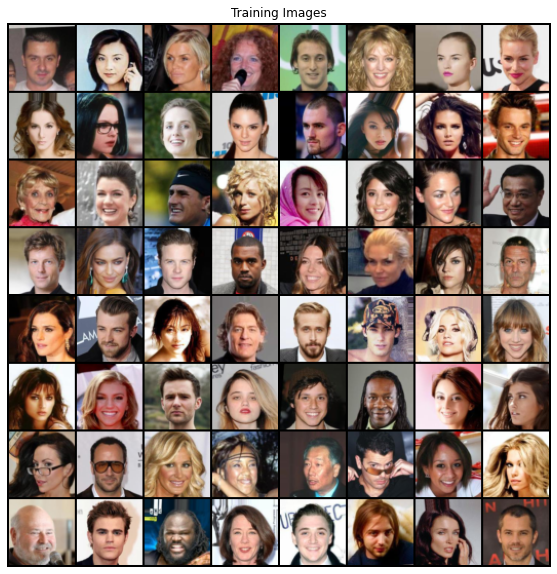

In [ ]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch_data[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Defining the Networks
Defining the Self Attention layer , Generator and the Discriminator Networks, Self Attention has been designed as per the concept introduced in Vaswani et.al's paper "Attention is All You Need" and Zhnang et.al's paper "Self Attention Generative Adversarial Networks"

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, ngpu, in_dim):
    super(SelfAttention, self).__init__()
    self.ngpu = ngpu # Here I am specifying the gpu for storage purposes and better matrix multiplication
    self.fx = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//2, kernel_size=1)
    self.gx = nn.Conv2d(in_channels= in_dim, out_channels= in_dim//2, kernel_size=1)
    self.hx = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
    self.gamma = nn.Parameter(torch.zeros(1)) # Creates a trainable parameter
    self.softmax = nn.Softmax(dim = -1)
  
  def forward(self, x):
    m_batch_size, C, width, height = x.size() # Returns a list , the first one contains the Batch_size, C  = No.of channels
    fx = self.fx(x).view(m_batch_size, -1, width*height).permute(0,2,1) # transpose the output of the previous layer matrix acording to definition, basically a vector is created by using view (x)
    gx = self.gx(x).view(m_batch_size, -1, width*height)
    hx = self.hx(x).view(m_batch_size, -1, width * height)
    product = torch.bmm(fx, gx) # Basically a dot product is calculated between the resultant tensors
    attention_map = self.softmax(product) # B *N * N
    out = torch.bmm(hx, attention_map.permute(0,2,1)) # Returns tensor of dimensions B * C *N
    #print("Output_shape",out.size())
    out = out.view(batch_size,C, width, height) # Returns Tensor of dimension B*C* W * H
    y = self.gamma * out +x
    y = y.view(m_batch_size, -1, width , height)
    return y

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngf, nz, no_of_channels):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(
                        nn.ConvTranspose2d(in_channels= nz,out_channels= ngf * 8, kernel_size=4, stride= 1, padding = 0),
                        nn.BatchNorm2d(ngf * 8),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=ngf * 8, out_channels= ngf * 4, kernel_size=4, stride = 2, padding = 1),
                        nn.BatchNorm2d(ngf*4),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=ngf * 4, out_channels= ngf * 2, kernel_size=4, stride=2,padding=1),
                        nn.BatchNorm2d(ngf * 2),
                        nn.ReLU(),
                        SelfAttention(ngpu, in_dim = ngf * 2),
                        nn.ConvTranspose2d(in_channels=ngf * 2, out_channels= ngf , kernel_size=4, stride=2,padding=1),
                        nn.BatchNorm2d(ngf),
                        nn.ReLU(),
                        SelfAttention(ngpu, in_dim = ngf),
                        nn.ConvTranspose2d(in_channels=ngf , out_channels= no_of_channels, kernel_size=4, stride=2,padding=1),
                        #nn.BatchNorm2d(no_of_channels),
                        nn.Tanh()                    
                        )
  def forward(self,input):
      return self.generator(input)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ndf, ngpu, no_of_channels):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.discriminator = nn.Sequential(
                            nn.Conv2d(in_channels=no_of_channels, out_channels= ndf, kernel_size=4, stride = 2, padding = 1),
                            nn.BatchNorm2d(ndf),
                            nn.LeakyReLU(0.1),
                            nn.Conv2d(in_channels=ndf, out_channels= ndf * 2, kernel_size=4,stride = 2, padding = 1 ),
                            nn.BatchNorm2d(ndf * 2),
                            nn.LeakyReLU(0.1),
                            nn.Conv2d(in_channels=ndf * 2, out_channels= ndf * 4, kernel_size= 4, stride=  2, padding = 1),
                            nn.BatchNorm2d(ndf * 4),
                            nn.LeakyReLU(0.1),
                            SelfAttention(ngpu, ndf * 4),
                            nn.Conv2d(in_channels = ndf * 4, out_channels = ndf * 8, kernel_size = 4, stride = 2, padding = 1),
                            nn.BatchNorm2d(ndf * 8),
                            nn.LeakyReLU(0.1),
                            SelfAttention(ngpu, in_dim = ndf * 8),
                            nn.Conv2d(in_channels= ndf * 8, out_channels = 1, kernel_size= 4, stride= 2, padding= 0),
                            #nn.BatchNorm2d(1),
                            
                          )
  def forward(self, input):
      out = self.discriminator(input)
      return out.squeeze()

In [ ]:
netGenerator = Generator(ngf, nz, no_of_channels).to(device)

In [ ]:
netDiscriminator = Discriminator(ndf, ngpu, no_of_channels).to(device)

In [ ]:
print(netGenerator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): SelfAttention(
      (fx): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (gx): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (hx): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
print(netDiscriminator)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): SelfAttention(
      (fx): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (gx): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (hx): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11)

## Defining the training Loop

In [ ]:
epochs = 1000
beta1 = 0
learning_rate_D = 0.0004
learning_rate_G = 0.0001

In [ ]:
real_label, fake_label = 1, 0

In [ ]:
def denorm(t):
  t = t.mul(0.5).add(0.5)
  t = t.clamp(0,1)
  return t

In [ ]:
def train(netDiscriminator, netGenerator, epoch, epochs, optimizerD, optimizerG, loss_Discriminator, loss_Generator):
  iters = 0
  PATH_TO_FAKE = '/content/gdrive/My Drive/Fake Images/'
  for epoch in range(epoch,epochs):
    for i, data in enumerate(dataloader,0):
      # Train Discriminator
      batch_data = data[0].to(device)
      b_size = batch_data.size(0)
      #label = torch.full(real_label, b_size, device = device)
      #print(batch_data.size())
      output_real = netDiscriminator(batch_data).view(-1) # Reshapes to a 128 sized tensor
      err_Discriminator_real = nn.ReLU()(1.0 - output_real).mean()
      noise = torch.randn(b_size, nz, 1, 1, device = device)
      fake_images = netGenerator(noise)
      output_fake = netDiscriminator(fake_images)
      errDiscrimator_fake = nn.ReLU()(1.0 + output_fake).mean()
      total_loss = err_Discriminator_real+errDiscrimator_fake
      netDiscriminator.zero_grad()
      netGenerator.zero_grad()
      total_loss.backward()
      optimizerD.step()
      #Train Generator
      #if epoch % 5 == 0:
      noise = torch.randn(b_size, nz, 1, 1, device = device)
      fake_images = netGenerator(noise)
      fake_outputs = netDiscriminator(fake_images)
      loss_Generator_fake = -fake_outputs.mean()
      netDiscriminator.zero_grad()
      netGenerator.zero_grad()
      loss_Generator_fake.backward()
      optimizerG.step()
      if(i%50 == 0):
        print('epoch', epoch,'Discrimator Loss', total_loss.item(), 'Generator Loss', loss_Generator_fake.item())
      loss_Discriminator.append(total_loss.item())
      loss_Generator.append(loss_Generator_fake.item())
      #Saving Model after every 100th epoch
      if (epoch % 100) == 0:
        checkpoint_discriminator = {
            'epoch' : epoch ,
            'discriminator_model_state_dict':netDiscriminator.state_dict(),
            'optimizer_discriminator_state_dict':optimizerD.state_dict(),
            'loss':loss_Discriminator
            }
        torch.save(checkpoint_discriminator,Discriminator_path)
        checkpoint_generator = {
            'epoch' : epoch ,
            'generator_model_state_dict':netGenerator.state_dict(),
            'optimizer_generator_state_dict':optimizerG.state_dict(),
            'loss':loss_Generator
            }
        torch.save(checkpoint_generator, Generator_path)
      if (epoch % 100 == 0) or ((epoch == epochs - 1) and (i == len(dataloader)-1)):
        fake = netGenerator(fixed_noise)
        path_to_save = os.path.join(PATH_TO_FAKE, 'Generator0_Epoch{}'.format(epoch))
        if os.path.exists(path_to_save):
          for i in range(fake.size()[0]):
            vutils.save_image(denorm(fake[i, :, :, :]),os.path.join(path_to_save,'{}_fake.png'.format(i)))
        else:
          os.mkdir(path_to_save)
          for i in range(fake.size()[0]):
            vutils.save_image(denorm(fake[i, :, :, :]),os.path.join(path_to_save,'{}_fake.png'.format(i)))
        #print(fake.size())
        #Saving for visualization purposes
        vutils.save_image(denorm(fake), os.path.join(PATH_TO_FAKE,'{}_fake_Generator0.png'.format(epoch)))
        #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      #iters += 1

In [ ]:
#loss = nn.BCELoss()
fixed_noise = torch.randn(batch_size, nz, 1,1, device= device)
optimizerD = optim.Adam(netDiscriminator.parameters(), lr = learning_rate_D, betas =  (beta1, 0.9))
optimizerG = optim.Adam(netGenerator.parameters(), lr = learning_rate_G, betas = (beta1, 0.9))
loss_Discriminator = []
loss_Generator = []
iters = 0
img_list = []
Discriminator_path = '/content/gdrive/My Drive/SAGAN Models/Discriminator_without_spectral_norm.pt'
Generator_path = '/content/gdrive/My Drive/SAGAN Models/Generator_without_spectral_norm.pt'

In [ ]:
train(netDiscriminator, netGenerator, 0, epochs, optimizerD, optimizerG,loss_Discriminator, loss_Generator)

epoch 0 Discrimator Loss 1.920360803604126 Generator Loss 3.2410247325897217
epoch 0 Discrimator Loss 0.0 Generator Loss 4.451475143432617
epoch 0 Discrimator Loss 0.0 Generator Loss 9.003101348876953
epoch 0 Discrimator Loss 0.0 Generator Loss 5.633877754211426
epoch 0 Discrimator Loss 0.0 Generator Loss 5.357873916625977
epoch 0 Discrimator Loss 0.024974139407277107 Generator Loss 6.218600273132324
epoch 0 Discrimator Loss 0.0 Generator Loss 3.429116725921631
epoch 0 Discrimator Loss 0.0 Generator Loss 2.894364356994629
epoch 0 Discrimator Loss 0.0 Generator Loss 4.620913982391357
epoch 0 Discrimator Loss 0.20320819318294525 Generator Loss 9.073065757751465
epoch 0 Discrimator Loss 0.059598203748464584 Generator Loss 17.4644775390625
epoch 0 Discrimator Loss 0.0 Generator Loss 7.806585788726807
epoch 0 Discrimator Loss 0.0 Generator Loss 9.955479621887207
epoch 0 Discrimator Loss 2.0452985763549805 Generator Loss 9.365741729736328
epoch 0 Discrimator Loss 0.0 Generator Loss 7.4543504

KeyboardInterrupt: ignored

In [ ]:
Discriminator_checkpoint = torch.load(Discriminator_path)
Generator_checkpoint = torch.load(Generator_path)

In [ ]:
netDiscriminator.load_state_dict(Discriminator_checkpoint['discriminator_model_state_dict'])
optimizerD.load_state_dict(Discriminator_checkpoint['optimizer_discriminator_state_dict'])
netGenerator.load_state_dict(Generator_checkpoint['generator_model_state_dict'])
optimizerG.load_state_dict(Generator_checkpoint['optimizer_generator_state_dict'])
loss_Discriminator = Discriminator_checkpoint['loss']
loss_Generator = Generator_checkpoint['loss']

In [ ]:
epoch = Discriminator_checkpoint['epoch']

In [ ]:
epoch

400

In [ ]:
train(netDiscriminator,netGenerator, epoch, epochs, optimizerD, optimizerG, loss_Discriminator, loss_Generator )

Streaming output truncated to the last 5000 lines.
epoch 437 Discrimator Loss 0.11649305373430252 Generator Loss 16.946998596191406
epoch 437 Discrimator Loss 0.0 Generator Loss 18.334745407104492
epoch 437 Discrimator Loss 0.1289505809545517 Generator Loss 33.67536163330078
epoch 437 Discrimator Loss 0.027214504778385162 Generator Loss 14.604829788208008
epoch 437 Discrimator Loss 0.024664148688316345 Generator Loss 24.78223419189453
epoch 437 Discrimator Loss 0.0 Generator Loss 25.023025512695312
epoch 437 Discrimator Loss 0.0 Generator Loss 10.831408500671387
epoch 437 Discrimator Loss 0.09861288964748383 Generator Loss 12.421125411987305
epoch 437 Discrimator Loss 0.32672810554504395 Generator Loss 25.346343994140625
epoch 437 Discrimator Loss 0.09557435661554337 Generator Loss 16.856311798095703
epoch 437 Discrimator Loss 0.0 Generator Loss 15.86343002319336
epoch 437 Discrimator Loss 0.0 Generator Loss 17.316694259643555
epoch 437 Discrimator Loss 0.0 Generator Loss 15.4441089630

In [ ]:
epoch_set = np.linspace(1,500, num = 500, dtype = 'int')

In [ ]:
69312 / 64

1083.0

In [ ]:
len(loss_Generator)

654132

In [ ]:
loss_Generator

[3.2410247325897217,
 2.2693309783935547,
 8.406341552734375,
 1.2607100009918213,
 8.172712326049805,
 6.107320308685303,
 3.83017635345459,
 2.397545337677002,
 11.623125076293945,
 7.393983840942383,
 5.101538181304932,
 2.725464105606079,
 11.431390762329102,
 9.183087348937988,
 7.3468017578125,
 5.8389387130737305,
 3.9699463844299316,
 3.3518223762512207,
 11.042852401733398,
 8.171786308288574,
 6.417570114135742,
 4.787214279174805,
 2.6513304710388184,
 15.339811325073242,
 10.303313255310059,
 7.649121284484863,
 4.6618971824646,
 9.449450492858887,
 8.10445785522461,
 6.1107635498046875,
 3.7960240840911865,
 14.777267456054688,
 9.4989013671875,
 7.526223659515381,
 5.257772445678711,
 5.523260116577148,
 6.3188018798828125,
 4.060097694396973,
 13.678936004638672,
 11.434612274169922,
 10.313325881958008,
 8.795534133911133,
 7.146193504333496,
 5.0330095291137695,
 14.660216331481934,
 12.36084270477295,
 11.108028411865234,
 9.890615463256836,
 8.379253387451172,
 6.667

In [ ]:
loss_G = []
for i in range(0,len(loss_Generator),1083):
  loss_G.append(np.mean(loss_Generator[i:i+1083]))

In [ ]:
loss_G = loss_G[0:500]

In [ ]:
loss_D = []
for i in range(0,len(loss_Discriminator),1083):
  loss_D.append(np.mean(loss_Discriminator[i:i+1083]))

In [ ]:
loss_D = loss_D[0:500]

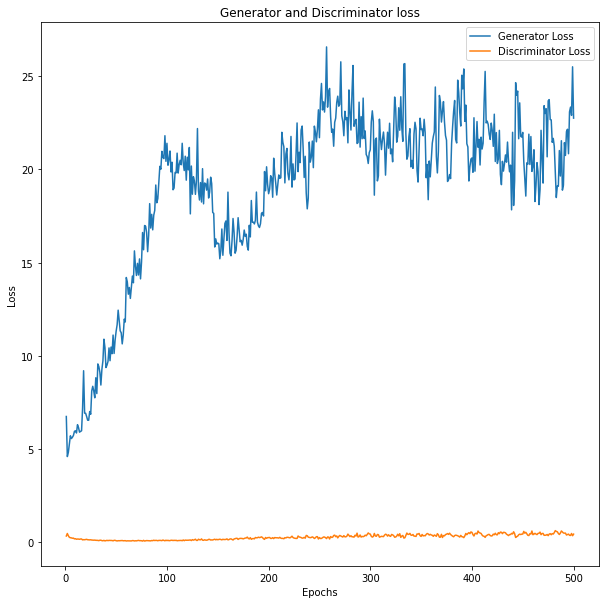

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epoch_set, loss_G, label = 'Generator Loss')
plt.plot(epoch_set, loss_D, label = 'Discriminator Loss')
plt.title('Generator and Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()